In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

import sys
sys.path.insert(0,'../src/')

from utils import *
import networkx as nx
from multiply_connected_pipe import *
from pipe_system import PipeSystem
from abstract_pipe import *

In [2]:
with open('pipes_and_shifts_built.pickle','rb') as f:
    pipes, shifts = pickle.load(f)

In [3]:
bdr_pipe = BoundaryPipe([BoundaryLet(-15,0,0,1,-1),BoundaryLet(15,0,np.pi,1,1)])
real_pipes = [RealPipe(p,shift_x=shift[0],shift_y=shift[1]) for p,shift in zip(pipes,shifts)]
lets = sorted([l for p in real_pipes for l in p.lets], key=lambda l: l.x)
lets[0], lets[-1]

(Let(x=-15.0, y=0.0, dir=3.141592653589793, dia=1.0),
 Let(x=15.0, y=0.0, dir=0.0, dia=1.0))

In [4]:
ps = PipeSystem(real_pipes,bdr_pipe)

In [5]:
[l.matching_pt for l in pipes[0].lets]

[array([-15.,   0.]), array([ 0., -2.]), array([0., 2.])]

In [6]:
pipes[0].pressure_drops

array([[46.94781863, 14.98241106],
       [14.98241106, 46.94781863]])

In [7]:
xs, ys, u_field, v_field, p_field, o_field = ps.plotting_data()

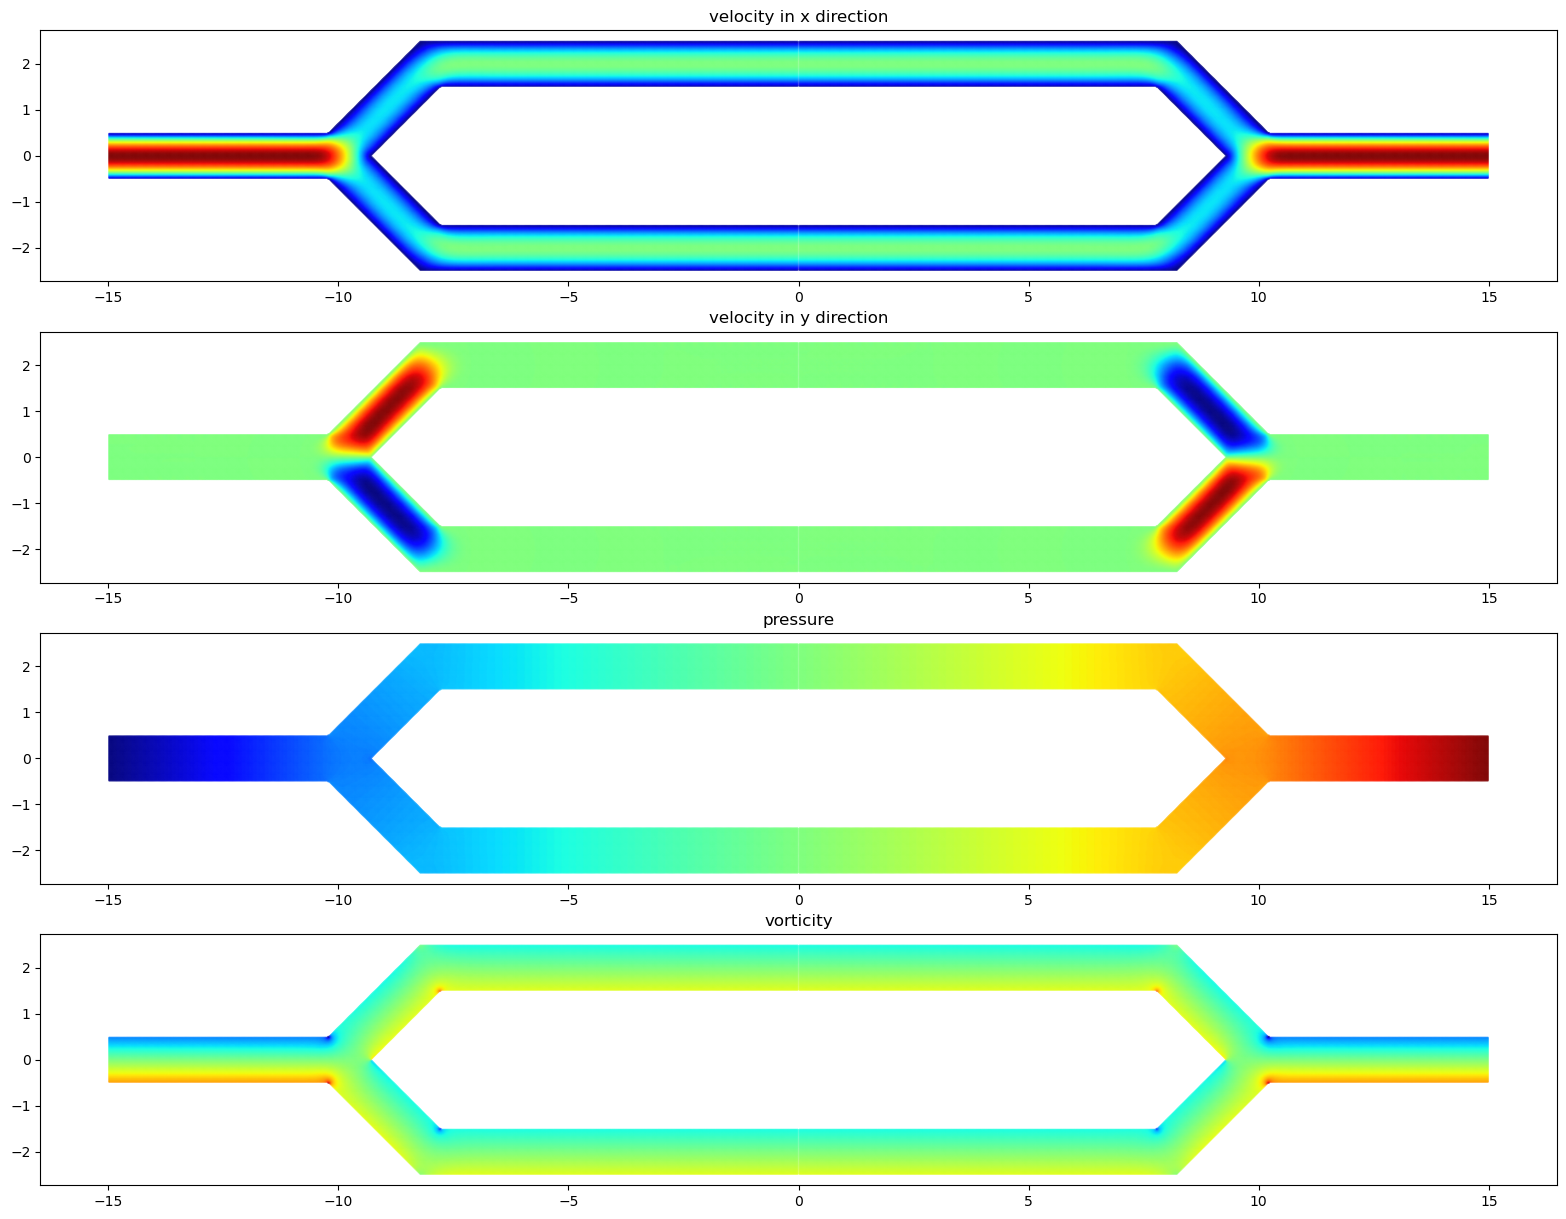

In [8]:
fig,axes = plt.subplots(4,1,figsize=(20,15))

for ax, field, title, in zip(axes, [u_field,v_field,p_field,o_field], ['velocity in x direction','velocity in y direction','pressure','vorticity']):
    ax.set_aspect('equal')
    ax.scatter(xs,ys,c=field,s=0.1,cmap='jet',)
    
    ax.set_title(title)
    # for a,i,j in zip(range(10),pipes,shifts):
    #     panel_break_pts = np.array([cplx2pt(p.start_pt) + j for p in i.panels])
    #     ax.scatter(panel_break_pts[:,0], panel_break_pts[:,1],c='black',s=1,marker='x')

In [9]:
with open('global_pipe_built.pickle','rb') as f:
    global_pipe = pickle.load(f)

In [10]:
for p in global_pipe.panels: p._build()
velocity = global_pipe.velocity(xs,ys,global_pipe.omegas[0])
pressure, vorticity = global_pipe.pressure_and_vorticity(xs,ys,global_pipe.omegas[0])
offset = np.quantile(pressure-p_field,.5)
pressure -= offset

/home/haiy/pkg/fmm2d/python/fmm2dpy/fmm2d.py:894: ComplexWarning: Casting complex values to real discards the imaginary part
  out.pottarg,out.gradtarg,out.ier = lfmm.cfmm2d_t_d_g(eps,sources,dipstr,targets)


In [11]:
p_diff = np.log10(np.abs(pressure-p_field))
o_diff = np.log10(np.abs(vorticity-o_field))
u_diff = np.log10(np.linalg.norm(np.array([u_field,v_field]) - velocity.T,axis=0))

vmax = np.max(np.array([p_diff,o_diff,u_diff]))
vmin = max(np.min(np.array([p_diff,o_diff,u_diff])),-20)

/tmp/ipykernel_24096/2447502227.py:1: RuntimeWarning: divide by zero encountered in log10
  p_diff = np.log10(np.abs(pressure-p_field))


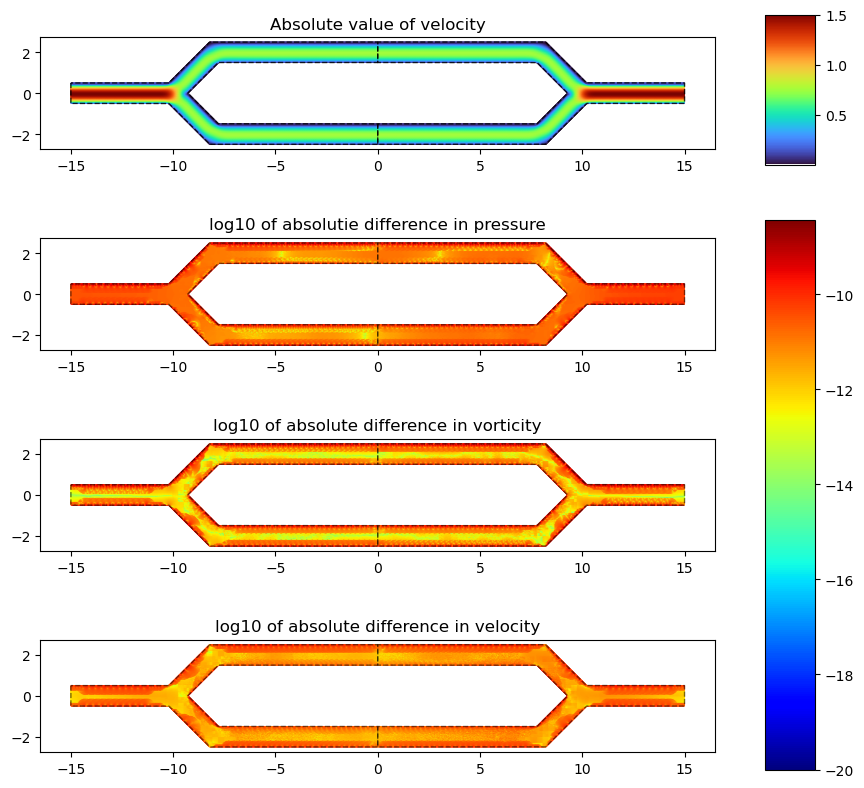

In [12]:
fig, axes = plt.subplots(4,1,figsize=(10,10))

ax = axes[0]
ax.set_aspect('equal')
im1 = ax.scatter(xs,ys,c=np.linalg.norm(np.array([u_field,v_field]),axis=0),s=0.1, cmap='turbo')
ax.set_title("Absolute value of velocity")

for a,i,j in zip(range(22),pipes,shifts):
    ax.plot(*(i.exterior_boundary.plyg_bdr() + j).T,'--k',alpha=0.8,linewidth=1)
    
for ax, diff, title in zip(axes[1:], [p_diff, o_diff, u_diff], ['log10 of absolutie difference in pressure', 'log10 of absolute difference in vorticity', 'log10 of absolute difference in velocity']):
    ax.set_aspect('equal')
    im = ax.scatter(xs,ys,c=diff,s=0.1, vmin=vmin,vmax=vmax,cmap='jet')
    ax.set_title(title)
    
    for a,i,j in zip(range(22),pipes,shifts):
        ax.plot(*(i.exterior_boundary.plyg_bdr() + j).T,'--k',alpha=0.5,linewidth=1)
    

fig.subplots_adjust(right=0.8)
cbar_ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.55])
fig.colorbar(im, cax=cbar_ax2)
cbar_ax1 = fig.add_axes([0.85, 0.725, 0.05, 0.15])
fig.colorbar(im1, cax=cbar_ax1)

In [13]:
def projection(t, start_pt,end_pt):
    pts = np.array([t.real,t.imag]).T
    v = end_pt - start_pt
    proj = (np.dot(pts - start_pt, v)) / np.linalg.norm(v)**2
    proj = np.array([p*v for p in proj])
    return proj + start_pt

In [15]:
pipe1,pipe2 = pipes

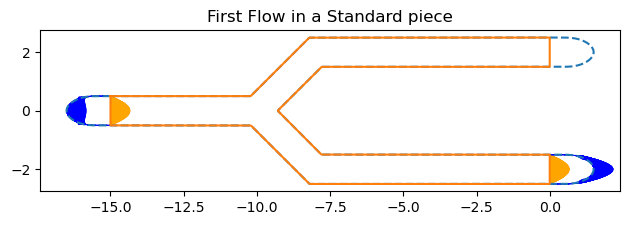

In [16]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
ax.plot(pipe1.t.real,pipe1.t.imag,'--')
ax.plot(*pipe1.exterior_boundary.plyg_bdr().T)
cap0, cap1, cap2 = pipe1.lets
_u, _v = -H2U(cap0.boundary_velocity()).T
p = projection(cap0.t, cap0.start_pt, cap0.end_pt)
ax.quiver(p[:,0], p[:,1], _u, _v,color='orange')
ax.quiver(cap0.t.real, cap0.t.imag, _u, _v,color='blue')

_u, _v = H2U(cap1.boundary_velocity()).T
p = projection(cap1.t, cap1.start_pt, cap1.end_pt)
ax.quiver(p[:,0], p[:,1], _u, _v,color='orange')
ax.quiver(cap1.t.real, cap1.t.imag, _u, _v,color='blue')
ax.set_title("First Flow in a Standard piece")

fig.tight_layout()
fig.savefig('superficial_cap_demo.png')

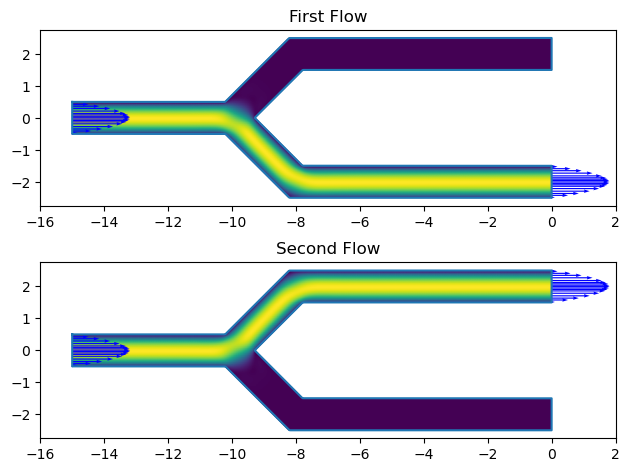

In [17]:
fig, (ax1,ax2) = plt.subplots(2,1)

n = 40
w = 0.002

ax1.set_aspect('equal')
# ax1.plot(pipe1.t.real,pipe1.t.imag,'--')
ax1.plot(*pipe1.exterior_boundary.plyg_bdr().T)
cap0, cap1, cap2 = pipe1.lets
_u, _v = -H2U(cap0.boundary_velocity()).T
p = projection(cap0.t, cap0.start_pt, cap0.end_pt)
ax1.scatter(pipe1.xs,pipe1.ys, s=0.1, c=(pipe1.u_fields[0]**2 + pipe1.v_fields[0]**2)**0.5)
ax1.quiver(p[::n,0], p[::n,1], _u[::n], _v[::n],color='blue',width=w)
# ax1.quiver(cap0.t.real, cap0.t.imag, _u, _v,color='blue')

_u, _v = H2U(cap1.boundary_velocity()).T
p = projection(cap1.t, cap1.start_pt, cap1.end_pt)
ax1.quiver(p[::n,0], p[::n,1], _u[::n], _v[::n],color='blue',width=w)
# ax1.quiver(cap1.t.real, cap1.t.imag, _u, _v,color='blue')
ax1.set_title("First Flow")

ax2.set_aspect('equal')
# ax2.plot(pipe1.t.real,pipe1.t.imag,'--')
ax2.plot(*pipe1.exterior_boundary.plyg_bdr().T)
ax2.scatter(pipe1.xs,pipe1.ys, s=0.1, c=(pipe1.u_fields[1]**2 + pipe1.v_fields[1]**2)**0.5)


_u, _v = -H2U(cap0.boundary_velocity()).T
p = projection(cap0.t, cap0.start_pt, cap0.end_pt)
ax2.quiver(p[::n,0], p[::n,1], _u[::n], _v[::n],color='blue',width=w)
# ax2.quiver(cap0.t.real, cap0.t.imag, _u, _v,color='blue')

_u, _v = H2U(cap2.boundary_velocity()).T
p = projection(cap2.t, cap2.start_pt, cap2.end_pt)
ax2.quiver(p[::n,0], p[::n,1], _u[::n], _v[::n],color='blue',width=w)
# ax2.quiver(cap2.t.real, cap2.t.imag, _u, _v,color='blue')
ax2.set_title("Second Flow")

ax1.set_xlim(-16,2)
ax2.set_xlim(-16,2)

fig.tight_layout()
fig.savefig('standard_pipe_flows_demo.png')

In [18]:
t = 23


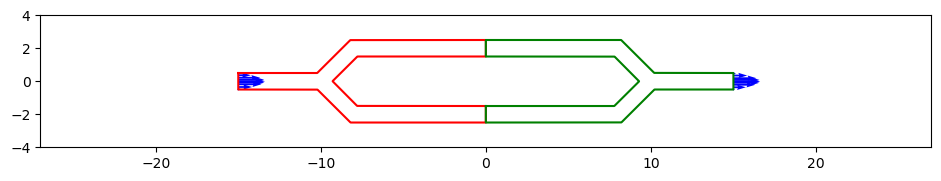

In [19]:
fig,ax = plt.subplots(figsize=(t/2,2))
ax.set_aspect('equal')

for a,i,j,c in zip(range(10),pipes,shifts,'rg'):
    ax.plot(*(i.exterior_boundary.plyg_bdr() + j).T,c=c)

n = 80
width = 0.00001

cap0 = pipe1.lets[0]
_u, _v = -H2U(cap0.boundary_velocity()).T
p = projection(cap0.t, cap0.start_pt, cap0.end_pt)

ax.quiver(p[::n,0], p[::n,1], _u[::n], _v[::n],color='blue',width=w, scale=50)

cap1 = pipes[-1].lets[1]
_u, _v = -H2U(cap0.boundary_velocity()).T
p = projection(cap1.t, cap1.start_pt, cap1.end_pt)
ax.quiver(p[::n,0], p[::n,1], _u[::n], _v[::n],color='blue',width=w, scale=50)

ax.set_xlim(-27,27)
ax.set_ylim(-4,4)
fig.savefig('simple-interface-problem.png')

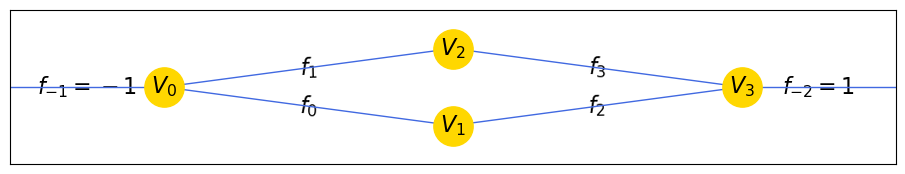

In [20]:
fig,ax = plt.subplots(figsize=(t/2,2))
ax.set_aspect('equal')

G = nx.Graph()

G.add_node((-15,0))
G.add_node((0,-2))
G.add_node((0,2))
G.add_node((15,0))
G.add_edge((-15,0),(0,-2))
G.add_edge((-15,0),(0,2))
G.add_edge((15,0),(0,-2))
G.add_edge((15,0),(0,2))


G.add_node((-t,0))
G.add_edge((-t,0),(-15,0))
G.add_node((t,0))
G.add_edge((15,0),(t,0))
node_list = list(G.nodes)
labels = {v:r'$V_{' + str(i) + '}$' for i,v in enumerate(node_list)}
labels[(-t,0)] = ''
labels[(t,0)] = ''

edge_labels={(v1,v2):r'$f_{' + str(i) + '}$' for i,(v1,v2) in enumerate(G.edges())}
edge_labels[((-t,0),(-15,0))] = r'$f_{-1}=-1$'
edge_labels[((15,0),(t,0))] = r'$f_{-2}=1$'
edge_labels[(15,0),(0,-2)] = r'$f_{2}$'
edge_labels[(15,0),(0,2)] = r'$f_{3}$'

node_list.remove((-t,0))
node_list.remove((t,0))

fs = 16
nx.draw_networkx_edge_labels(
    G,ax=ax,font_size=fs,
    pos={n:n for n in G.nodes()},
    edge_labels=edge_labels,
    )

nx.draw_networkx(
    G,ax=ax,node_color='gold',edge_color='royalblue',font_size=fs,nodelist=node_list,
    pos={v:v for v in G.nodes()},
    labels=labels,node_size=800,
    )

ax.set_xlim(-t,t)
ax.set_ylim(-4,4)

fig.savefig('simple-interface-problem-network.png')

In [22]:
np.linalg.lstsq(ps.A,ps.b)[0] - np.array([0.5,0.5,1,-0.5])

/tmp/ipykernel_24096/4079834195.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  np.linalg.lstsq(ps.A,ps.b)[0] - np.array([0.5,0.5,1,-0.5])


array([-4.00790512e-14,  5.17363929e-14, -1.33226763e-15, -4.28546088e-14])

In [23]:
pipes[0].pressure_drops

array([[46.94781863, 14.98241106],
       [14.98241106, 46.94781863]])

In [ ]:
ps.A[-1]

array([-31.24618906,  31.29518093, -31.31740264, -62.57812857])

In [24]:
ps.A[-1]

array([-31.96540757,  31.96540757, -31.96540757, -63.93081514])